In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import statsmodels.api as sm
import warnings
from sklearn.metrics import r2_score
from pandas.core.nanops import nanmean as pd_nanmean
from pandas.plotting import register_matplotlib_converters
from pylab import rcParams

# I Исследование ряда на стационарность 

Считываем данные из training.xlsx

In [5]:
train = pd.read_excel('training.xlsx', index_col='Date')
train.tail()

,Value
Date,
1988-08-01,63.8851
1988-09-01,63.7040
1988-10-01,64.0220
1988-11-01,64.1173
1988-12-01,64.4210


Исходный ряд и различные скользящие (средние)

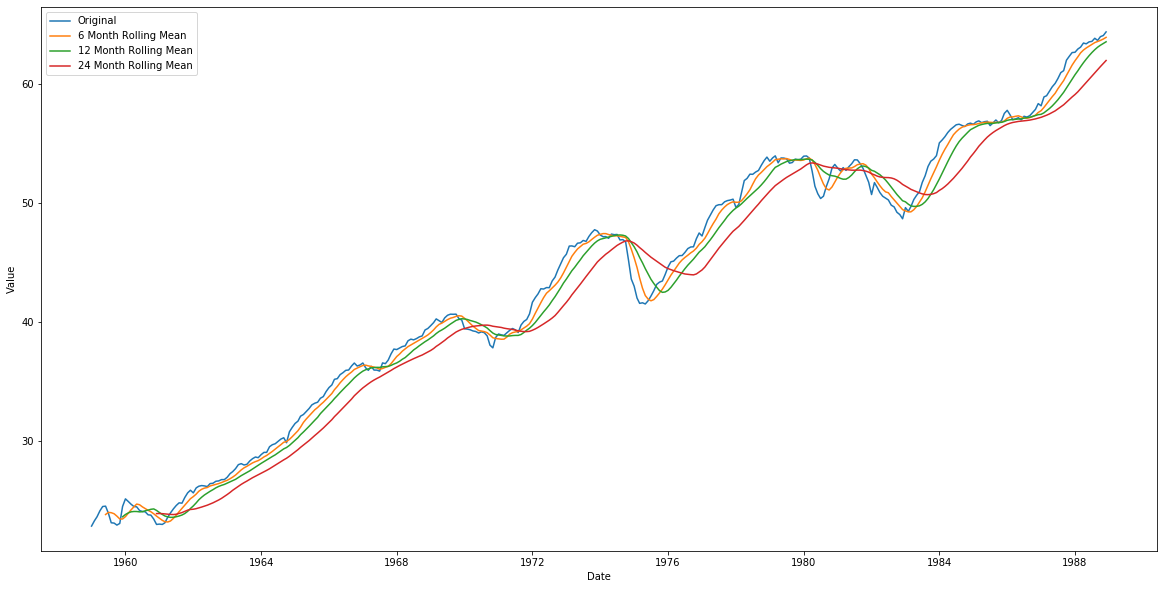

In [6]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=train.index, y=train.Value, label='Original')
sns.lineplot(
    x=train.index,
    y=train.Value.rolling(6).mean(),
    label='6 Month Rolling Mean')
sns.lineplot(
    x=train.index,
    y=train.Value.rolling(12).mean(),
    label='12 Month Rolling Mean')
sns.lineplot(
    x=train.index,
    y=train.Value.rolling(24).mean(),
    label='24 Month Rolling Mean')
plt.show()

Исходный ряд и различные скользящие (стандартные отклонения)

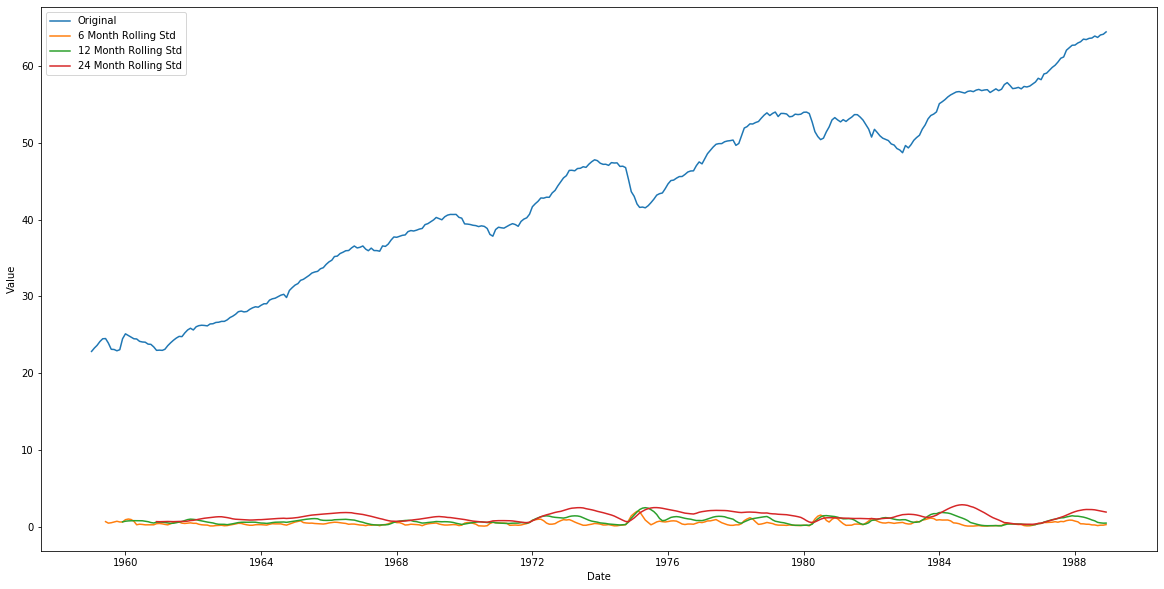

In [7]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=train.index, y=train.Value, label='Original')
sns.lineplot(
    x=train.index,
    y=train.Value.rolling(6).std(),
    label='6 Month Rolling Std')
sns.lineplot(
    x=train.index,
    y=train.Value.rolling(12).std(),
    label='12 Month Rolling Std')
sns.lineplot(
    x=train.index,
    y=train.Value.rolling(24).std(),
    label='24 Month Rolling Std')
plt.show()

Вывод: Визуальная оценка показывает , что в ряде присутствует тренд , следовательно исходный ряд не стационарен.

# II Разложение на тренд , сезональность и остаток в соответствии с аддитивной и мультипликативной моделями

# Additive model

In [9]:
def seasonal_dec_add(train, n):
    T = train.rolling(n).mean()
    DeT = train - T

    def seasonal_mean(x, period):
        return np.array([pd_nanmean(x[i::period], axis=0)
                         for i in range(period)])

    seasonarr = seasonal_mean(DeT, n)

    sum = 0
    for i in range(n):
        sum += seasonarr[i]
    seasonarr -= (sum / n)

    S = np.tile(seasonarr.T, DeT.shape[0] // n + 1).T[:DeT.shape[0]]
    R = train - T - S
    return T, S, R


inf = seasonal_dec_add(train.Value, 18)

Тренд

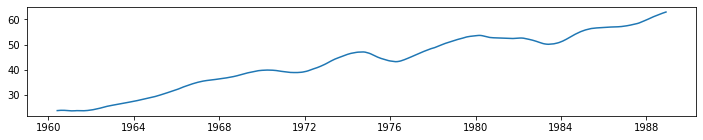

In [10]:
plt.figure(figsize=(12, 2))
sns.lineplot(data=inf[0])
plt.show()

Визуальная оценка показывает , что тренд не стационарен

Сезонность

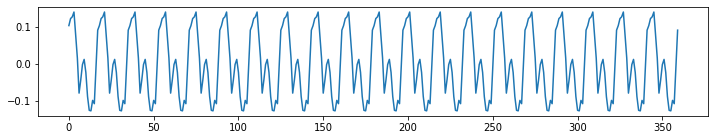

In [11]:
plt.figure(figsize=(12, 2))
sns.lineplot(data=inf[1])
plt.show()

In [12]:
test = sm.tsa.adfuller(inf[1])
if test[0] > test[4]['5%']:
    print('Сезонность не стационарна (присутствуют единичные корни)')
else:
    print('Сезонность стационарна (отсутствуют единичные корни)')

Сезонность стационарна (отсутствуют единичные корни)


Остаток

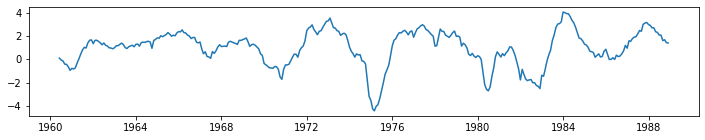

In [13]:
plt.figure(figsize=(12, 2))
sns.lineplot(data=inf[2])
plt.show()

In [14]:
inf[2].dropna(inplace=True)
test = sm.tsa.adfuller(inf[2])
if test[0] > test[4]['5%']:
    print('Остаток не стационарен (присутствуют единичные корни)')
else:
    print('Остаток стационарен (отсутствуют единичные корни)')

Остаток стационарен (отсутствуют единичные корни)


# Multiplicative model

Тренд

In [15]:
def seasonal_dec_mult(train, n):
    T = train.rolling(n).mean()
    DeT = train / T

    def seasonal_mean(x, period):
        return np.array([pd_nanmean(x[i::period], axis=0)
                         for i in range(period)])

    seasonarr = seasonal_mean(DeT, n)

    S = np.tile(seasonarr.T, DeT.shape[0] // n + 1).T[:DeT.shape[0]]
    R = train / T / S
    return T, S, R


inf = seasonal_dec_mult(train.Value, 18)

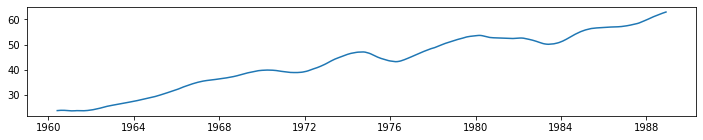

In [16]:
plt.figure(figsize=(12, 2))
sns.lineplot(data=inf[0])
plt.show()

Визуальная оценка показывает , что тренд не стационарен

Сезонность

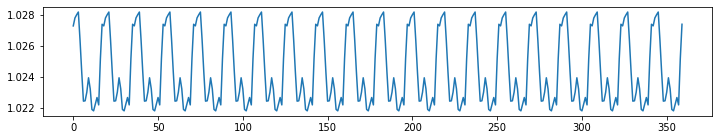

In [17]:
plt.figure(figsize=(12, 2))
sns.lineplot(data=inf[1])
plt.show()

In [18]:
test = sm.tsa.adfuller(inf[1])
if test[0] > test[4]['5%']:
    print('Сезонность не стационарна (присутствуют единичные корни)')
else:
    print('Сезонность стационарна (отсутствуют единичные корни)')


Сезонность стационарна (отсутствуют единичные корни)


Остаток

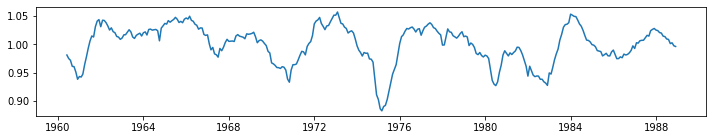

In [19]:
plt.figure(figsize=(12, 2))
sns.lineplot(data=inf[2])
plt.show()

In [20]:
inf[2].dropna(inplace=True)
test = sm.tsa.adfuller(inf[2])
if test[0] > test[4]['5%']:
    print('Остаток не стационарен (присутствуют единичные корни)')
else:
    print('Остаток стационарен (отсутствуют единичные корни)')


Остаток стационарен (отсутствуют единичные корни)


## III

Определим порядок интегрированности k с помощью ADF

In [21]:
def ADF_test(serie):
    k = 0
    for i in range(0, 5):
        if i != 0:
            d_serie = serie.diff(periods=i).dropna()
        else:
            d_serie = serie.dropna()
        test = sm.tsa.adfuller(d_serie)
        print('int-level : ', i)
        if (test[0] > test[4]['5%']):
            print('Eсть единичные корни, ряд не стационарен')
        else:
            print('Eдиничных корней нет, ряд стационарен')
            k = i
            break
    print('Ряд порядка интегрируемости: ', k)


ADF_test(train.Value)


int-level :  0
Eсть единичные корни, ряд не стационарен
int-level :  1
Eдиничных корней нет, ряд стационарен
Ряд порядка интегрируемости:  1


Считываем данные из testing.xlsx

In [22]:
test = pd.read_excel('testing.xlsx', index_col='Date')
test.tail()

,Value
Date,
1993-08-01,67.5985
1993-09-01,67.9241
1993-10-01,68.4390
1993-11-01,68.7289
1993-12-01,69.0884


Функции автокорреляции и частичной автокорреляции

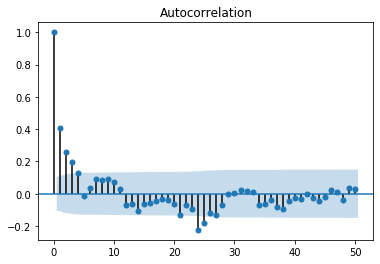

In [23]:
diff_s = train.Value.diff(periods=1).dropna()
fig = sm.graphics.tsa.plot_acf(diff_s.values.squeeze(), lags=50)

Номер последнего несезонного лага, при котором автокорреляция значима = 3

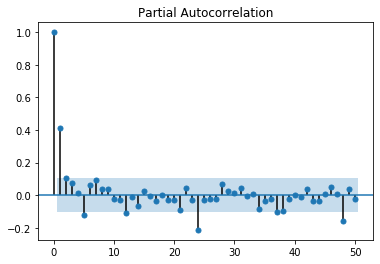

In [24]:
fig = sm.graphics.tsa.plot_pacf(diff_s, lags=50)

Номер последнего несезонного лага, при котором частичная автокорреляция значима = 1

In [1]:
def predict_it(train, test, supposition):
    model = sm.tsa.ARIMA(
        train.Value.squeeze(),
        order=supposition,
        freq='MS').fit()
    pred = model.predict(
        start=train.shape[0],
        end=train.shape[0] + test.shape[0] - 1,
        typ='levels')
    plt.figure(figsize=(15, 8))
    plt.plot(train.Value, label='Train')
    plt.plot(test.Value, color='grey', label='Test')
    plt.plot(pred, color='brown', label='ARIMA')
    plt.legend(loc='best')
    print('Score: {}'.format(r2_score(test.Value, pred)))
    print('Aiс: {}'.format(model.aic))
    plt.show()

Score: -3.320671860067619
Aiс: 251.08321143936848


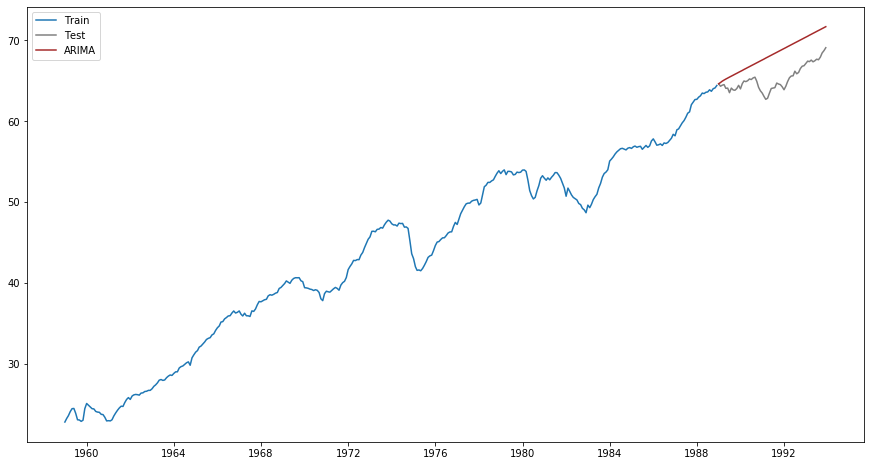

In [28]:
predict_it(train, test, (1, 1, 3))

Поиск других значений параметров p и q перебором

In [29]:
d = 1
result = {}
for p in range(10):
    for q in range(10):
        try:
            supposition = tuple(list(p, d, q))
            model = sm.tsa.ARIMA(train.Value, order=supposition).fit()
            result[supposition] = model.aic
        except:
            continue

result = sorted(models.items(), key=lambda k: k[1])

In [30]:
print(result[:3])

[((9, 1, 4), 241.22248892274274), ((8, 1, 2), 243.3907058417126), ((6, 1, 4), 244.18174915608301)]


/home/alexey/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Score: -4.019179676837993
Aiс: 241.22248892274274


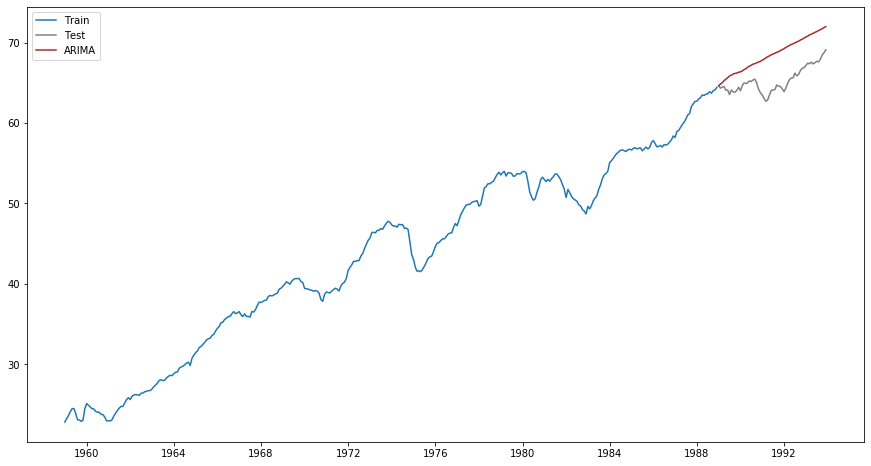

In [40]:
predict_it(train, test, (9, 1, 4))

Score: -3.77578507138493
Aiс: 243.3907058417126


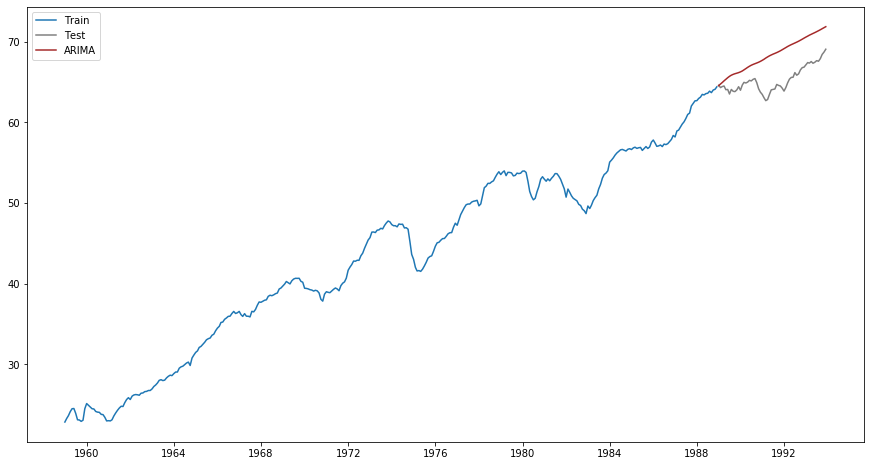

In [33]:
predict_it(train, test, (8, 1, 2))

Score: -3.529573678997113
Aiс: 244.18174915608301


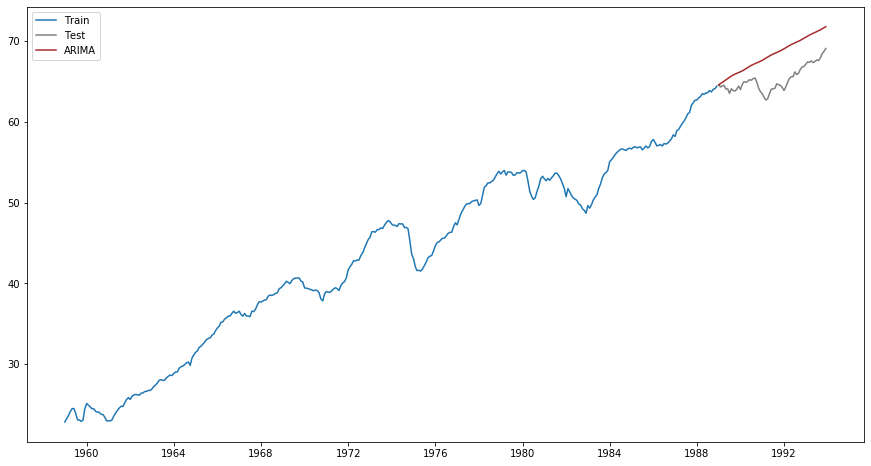

In [34]:
predict_it(train, test, (6, 1, 4))

Score: -3.281338125065072
Aiс: 248.73365724475116


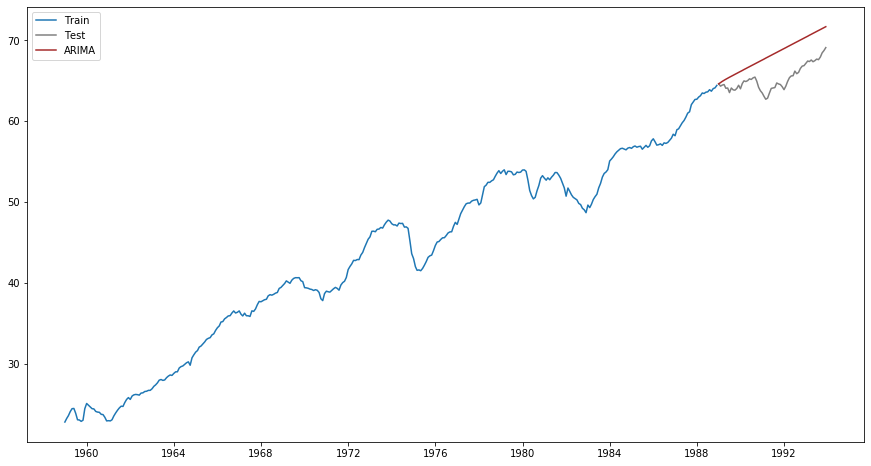

In [35]:
predict_it(train, test, (1, 1, 1))

Score: -3.305421965256474
Aiс: 250.62352240429288


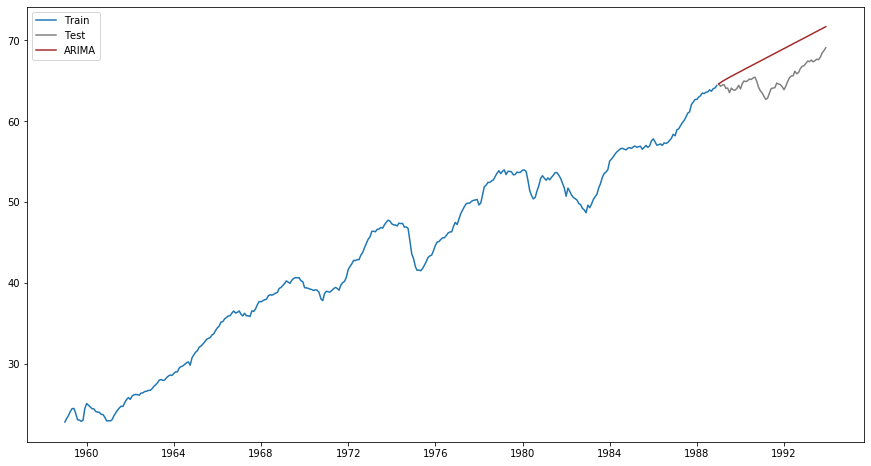

In [38]:
predict_it(train, test, (1, 1, 2))

Score: -3.297558158500139
Aiс: 250.66172836073235


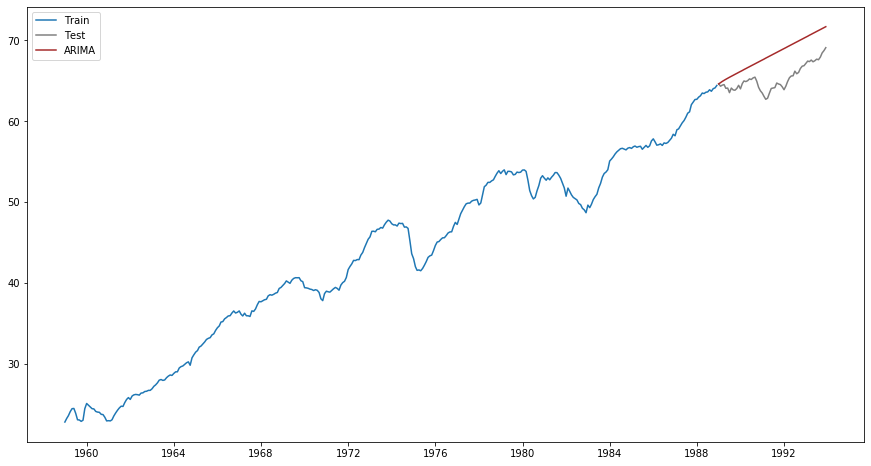

In [39]:
predict_it(train, test, (2, 1, 1))

Наилучшая модель , отобранная с помощью информационного критерия Акаике = (1, 1, 1)